<a href="https://colab.research.google.com/github/pacesatuinineh/Sift-Features/blob/main/1004_Gaussian%2BExplisit1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opencv-python
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 69.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 76.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.8 MB/s eta 0:00:00


In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import random
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
import warnings
warnings.filterwarnings("ignore")

In [3]:
#Gaussian Explisit Rule Skin Detection
def gamma_correction(image, gamma=1.2):
    """ Melakukan koreksi pencahayaan dengan Gamma Correction """
    invGamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** invGamma * 255 for i in range(256)]).astype("uint8")
    return cv2.LUT(image, table)

def skin_detection(image):
    """ Melakukan deteksi kulit berdasarkan aturan warna di ruang YCrCb dan HSV """
    # Konversi ke ruang warna YCrCb dan HSV
    image_YCrCb = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    image_HSV = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Mask YCrCb (kriteria warna kulit berdasarkan rentang nilai Cr dan Cb)
    lower_YCrCb = np.array([0, 133, 77], dtype=np.uint8)
    upper_YCrCb = np.array([255, 173, 127], dtype=np.uint8)
    mask_YCrCb = cv2.inRange(image_YCrCb, lower_YCrCb, upper_YCrCb)

    # Mask HSV (kriteria warna kulit berdasarkan rentang HSV)
    lower_HSV = np.array([0, 40, 50], dtype=np.uint8)
    upper_HSV = np.array([25, 255, 255], dtype=np.uint8)
    mask_HSV = cv2.inRange(image_HSV, lower_HSV, upper_HSV)

    # Gabungkan kedua mask
    mask = cv2.bitwise_and(mask_YCrCb, mask_HSV)

    # Terapkan mask pada gambar asli
    skin = cv2.bitwise_and(image, image, mask=mask)

    return skin

def preprocess_image(image_path, show_steps=False):
    # Step 1: Load Image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    if show_steps:
        plt.figure(figsize=(15, 6))
        plt.subplot(2, 4, 1)
        plt.imshow(image)
        plt.title("Original Image")

    # Step 2: Resolution Enhancement (Resizing with bilinear interpolation)
    image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_LINEAR)

    # Step 3: Gamma Correction (Illumination Correction)
    image = gamma_correction(image, gamma=1.2)

    if show_steps:
        plt.subplot(2, 4, 2)
        plt.imshow(image)
        plt.title("After Gamma Correction")

    # Step 4: Apply Gaussian Blur (Noise Reduction)
    image = cv2.GaussianBlur(image, (5, 5), 0)

    if show_steps:
        plt.subplot(2, 4, 3)
        plt.imshow(image)
        plt.title("After Gaussian Blur")

    # Step 5: Skin Detection
    image = skin_detection(image)

    if show_steps:
        plt.subplot(2, 4, 4)
        plt.imshow(image)
        plt.title("After Skin Detection")

    if len(image.shape) == 3 and image.shape[2] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Step 6: Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    image = clahe.apply(image)

    if show_steps:
        plt.subplot(2, 4, 5)
        plt.imshow(image, cmap="gray")
        plt.title("After CLAHE")

    # Step 7: Bilateral Filtering (Preserving Edges)
    image = cv2.bilateralFilter(image, 9, 75, 75)

    if show_steps:
        plt.subplot(2, 4, 6)
        plt.imshow(image, cmap="gray")
        plt.title("After Bilateral Filtering")

        plt.show()

    return image


In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


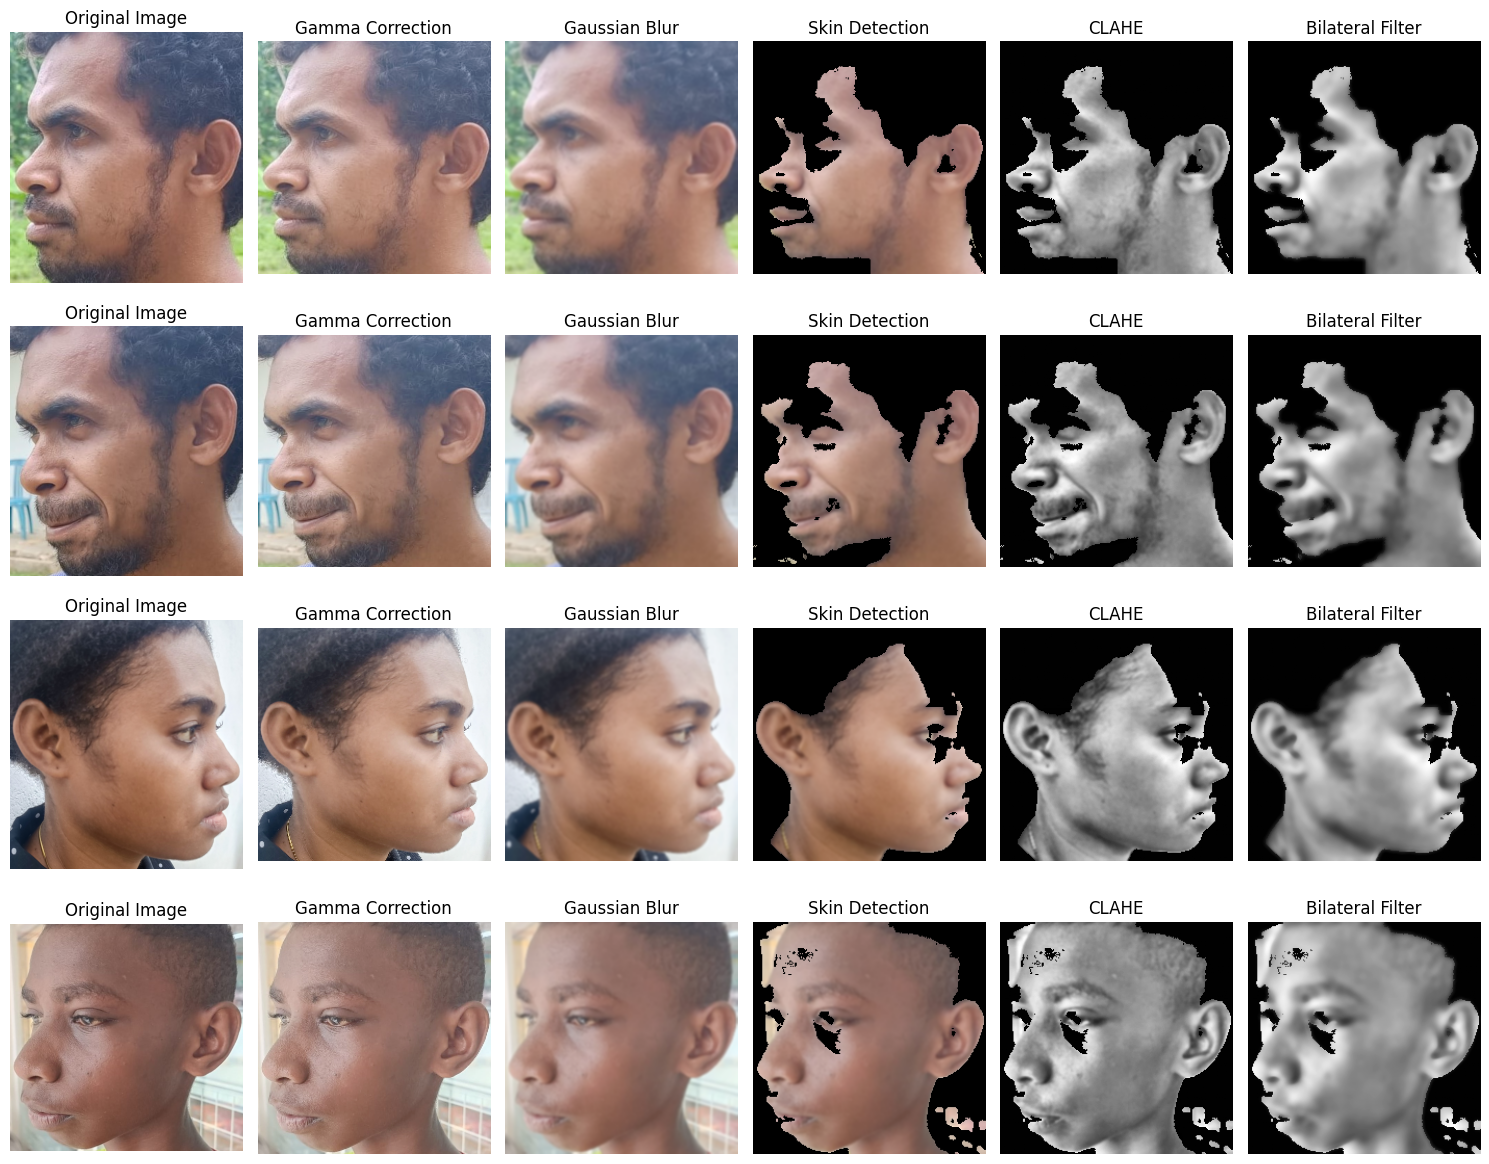

In [5]:
# Fungsi untuk menampilkan hasil preprocessing dari beberapa gambar
def visualize_preprocessing(image_paths):
    fig, axes = plt.subplots(len(image_paths), 6, figsize=(15, len(image_paths) * 3))

    for i, image_path in enumerate(image_paths):
        # Step 1: Load Image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        axes[i, 0].imshow(image)
        axes[i, 0].set_title("Original Image")
        axes[i, 0].axis("off")

        # Step 2: Resolution Enhancement (Resizing with bilinear interpolation)
        image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_LINEAR)

        # Step 3: Gamma Correction (Illumination Correction)
        image_gamma = gamma_correction(image, gamma=1.2)
        axes[i, 1].imshow(image_gamma)
        axes[i, 1].set_title("Gamma Correction")
        axes[i, 1].axis("off")

        # Step 4: Apply Gaussian Blur (Noise Reduction)
        image_blur = cv2.GaussianBlur(image_gamma, (5, 5), 0)
        axes[i, 2].imshow(image_blur)
        axes[i, 2].set_title("Gaussian Blur")
        axes[i, 2].axis("off")

        # Step 5: Skin Detection
        image_skin = skin_detection(image_blur)
        axes[i, 3].imshow(image_skin)
        axes[i, 3].set_title("Skin Detection")
        axes[i, 3].axis("off")

        # Convert to grayscale if needed
        if len(image_skin.shape) == 3 and image_skin.shape[2] == 3:
            image_gray = cv2.cvtColor(image_skin, cv2.COLOR_RGB2GRAY)
        else:
            image_gray = image_skin

        # Step 6: Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        image_clahe = clahe.apply(image_gray)
        axes[i, 4].imshow(image_clahe, cmap="gray")
        axes[i, 4].set_title("CLAHE")
        axes[i, 4].axis("off")

        # Step 7: Bilateral Filtering (Preserving Edges)
        image_final = cv2.bilateralFilter(image_clahe, 9, 75, 75)
        axes[i, 5].imshow(image_final, cmap="gray")
        axes[i, 5].set_title("Bilateral Filter")
        axes[i, 5].axis("off")

    plt.tight_layout()
    plt.show()

# Ambil semua gambar dari folder
image_folder = "/content/drive/MyDrive/WajahSorongRaya2/Moi"  # Sesuaikan dengan folder Anda
image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png'))]

# Pastikan ada minimal 4 gambar sebelum melakukan random sampling
if len(image_files) < 4:
    raise ValueError(f"Hanya ditemukan {len(image_files)} gambar, minimal 4 gambar diperlukan.")

# Pilih 4 gambar secara acak
random_images = random.sample(image_files, 4)

# Jalankan fungsi visualisasi
visualize_preprocessing(random_images)


In [6]:
# Update train_df and test_df to preprocess images
def data_df(data_path):
    """
    Create a DataFrame for training data with preprocessing applied to each image.
    """
    classes = []
    class_paths = []
    preprocessed_images = []

    # Loop through each class directory and preprocess the images
    for label in os.listdir(data_path):
        label_path = os.path.join(data_path, label)
        if os.path.isdir(label_path):  # Check if it is a directory
            for image in os.listdir(label_path):
                image_path = os.path.join(label_path, image)
                classes.append(label)
                class_paths.append(image_path)

                # Preprocess the image and store it
                processed_image = preprocess_image(image_path)
                preprocessed_images.append(processed_image)

    # Create a DataFrame with the preprocessed images and labels
    data = pd.DataFrame({'Class Path': class_paths, 'Class': classes, 'Processed Image': preprocessed_images})
    return data

In [7]:
# Generate the training and test DataFrames
data = data_df('/content/drive/MyDrive/WajahSorongRaya2')

In [8]:
data

Class Path    Class  \
0     /content/drive/MyDrive/WajahSorongRaya2/Maybra...  Maybrat   
1     /content/drive/MyDrive/WajahSorongRaya2/Maybra...  Maybrat   
2     /content/drive/MyDrive/WajahSorongRaya2/Maybra...  Maybrat   
3     /content/drive/MyDrive/WajahSorongRaya2/Maybra...  Maybrat   
4     /content/drive/MyDrive/WajahSorongRaya2/Maybra...  Maybrat   
...                                                 ...      ...   
1385  /content/drive/MyDrive/WajahSorongRaya2/Moi/IM...      Moi   
1386  /content/drive/MyDrive/WajahSorongRaya2/Moi/IM...      Moi   
1387  /content/drive/MyDrive/WajahSorongRaya2/Moi/IM...      Moi   
1388  /content/drive/MyDrive/WajahSorongRaya2/Moi/IM...      Moi   
1389  /content/drive/MyDrive/WajahSorongRaya2/Moi/IM...      Moi   

                                        Processed Image  
0     [[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...  
1     [[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...  
2     [[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...  
3     [[197, 198, 200, 201, 200, 195, 187, 168, 147,...  
4     [[190, 187, 177, 161, 146, 134, 128, 125, 125,...  
...                                                 ...  
1385  [[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...  
1386  [[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...  
1387  [[3, 4, 7, 14, 23, 88, 82, 82, 83, 79, 75, 74,...  
1388  [[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...  
1389  [[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...  

[1390 rows x 3 columns]

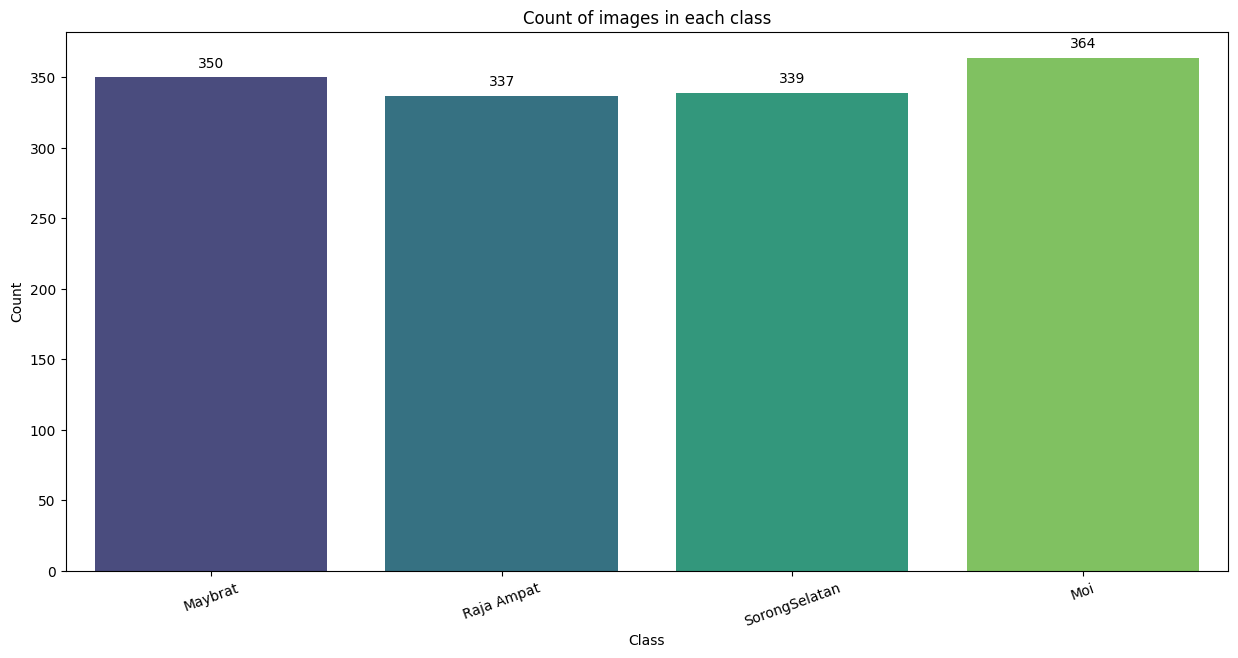

In [9]:
plt.figure(figsize=(15, 7))
ax = sns.countplot(x=data['Class'], palette='viridis')
ax.set(xlabel='Class', ylabel='Count', title='Count of images in each class')
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=5)
plt.xticks(rotation=20)
plt.show()

In [10]:
# Split the data into training and testing sets
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42, stratify=data['Class'])

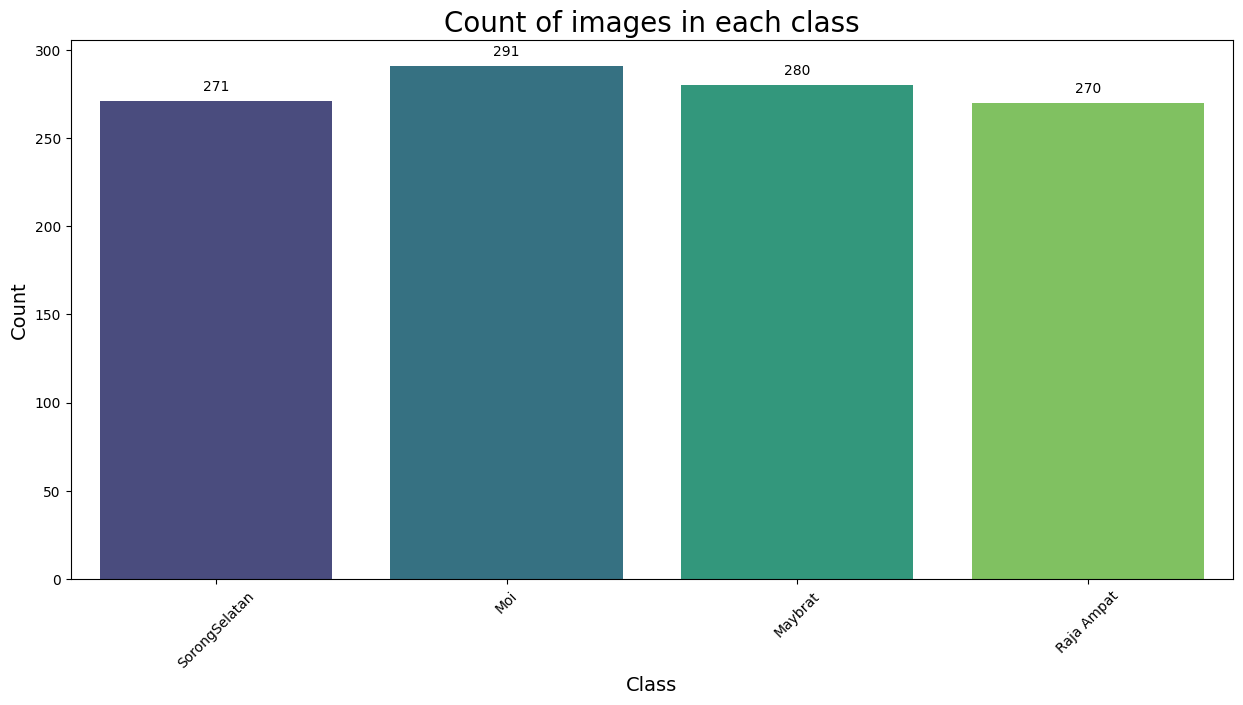

In [11]:
# Count of images in each class in train data
plt.figure(figsize=(15, 7))
ax = sns.countplot(data=train_df, x=train_df['Class'], palette='viridis')  # Ubah 'y' menjadi 'x'
plt.xlabel('Class', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Count of images in each class', fontsize=20)
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=5)
plt.xticks(rotation=45)
plt.show()

In [12]:
train_df

Class Path          Class  \
914   /content/drive/MyDrive/WajahSorongRaya2/Sorong...  SorongSelatan   
1371  /content/drive/MyDrive/WajahSorongRaya2/Moi/IM...            Moi   
867   /content/drive/MyDrive/WajahSorongRaya2/Sorong...  SorongSelatan   
1180  /content/drive/MyDrive/WajahSorongRaya2/Moi/IM...            Moi   
255   /content/drive/MyDrive/WajahSorongRaya2/Maybra...        Maybrat   
...                                                 ...            ...   
595   /content/drive/MyDrive/WajahSorongRaya2/Raja A...     Raja Ampat   
10    /content/drive/MyDrive/WajahSorongRaya2/Maybra...        Maybrat   
2     /content/drive/MyDrive/WajahSorongRaya2/Maybra...        Maybrat   
381   /content/drive/MyDrive/WajahSorongRaya2/Raja A...     Raja Ampat   
745   /content/drive/MyDrive/WajahSorongRaya2/Sorong...  SorongSelatan   

                                        Processed Image  
914   [[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...  
1371  [[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...  
867   [[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...  
1180  [[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...  
255   [[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...  
...                                                 ...  
595   [[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...  
10    [[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...  
2     [[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...  
381   [[232, 232, 232, 232, 232, 232, 232, 232, 233,...  
745   [[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,...  

[1112 rows x 3 columns]

In [13]:
batch_size = 32
img_size = (224, 224)
_gen = ImageDataGenerator(rescale=1/255,
 brightness_range=(0.7, 1.3))
ts_gen = ImageDataGenerator(rescale=1/255)
tr_gen = _gen.flow_from_dataframe(train_df, x_col='Class Path',
 y_col='Class', batch_size=batch_size,
 target_size=img_size)
ts_gen = _gen.flow_from_dataframe(test_df, x_col='Class Path',
 y_col='Class', batch_size=16,
 target_size=img_size, shuffle=False)

Found 1112 validated image filenames belonging to 4 classes.
Found 278 validated image filenames belonging to 4 classes.


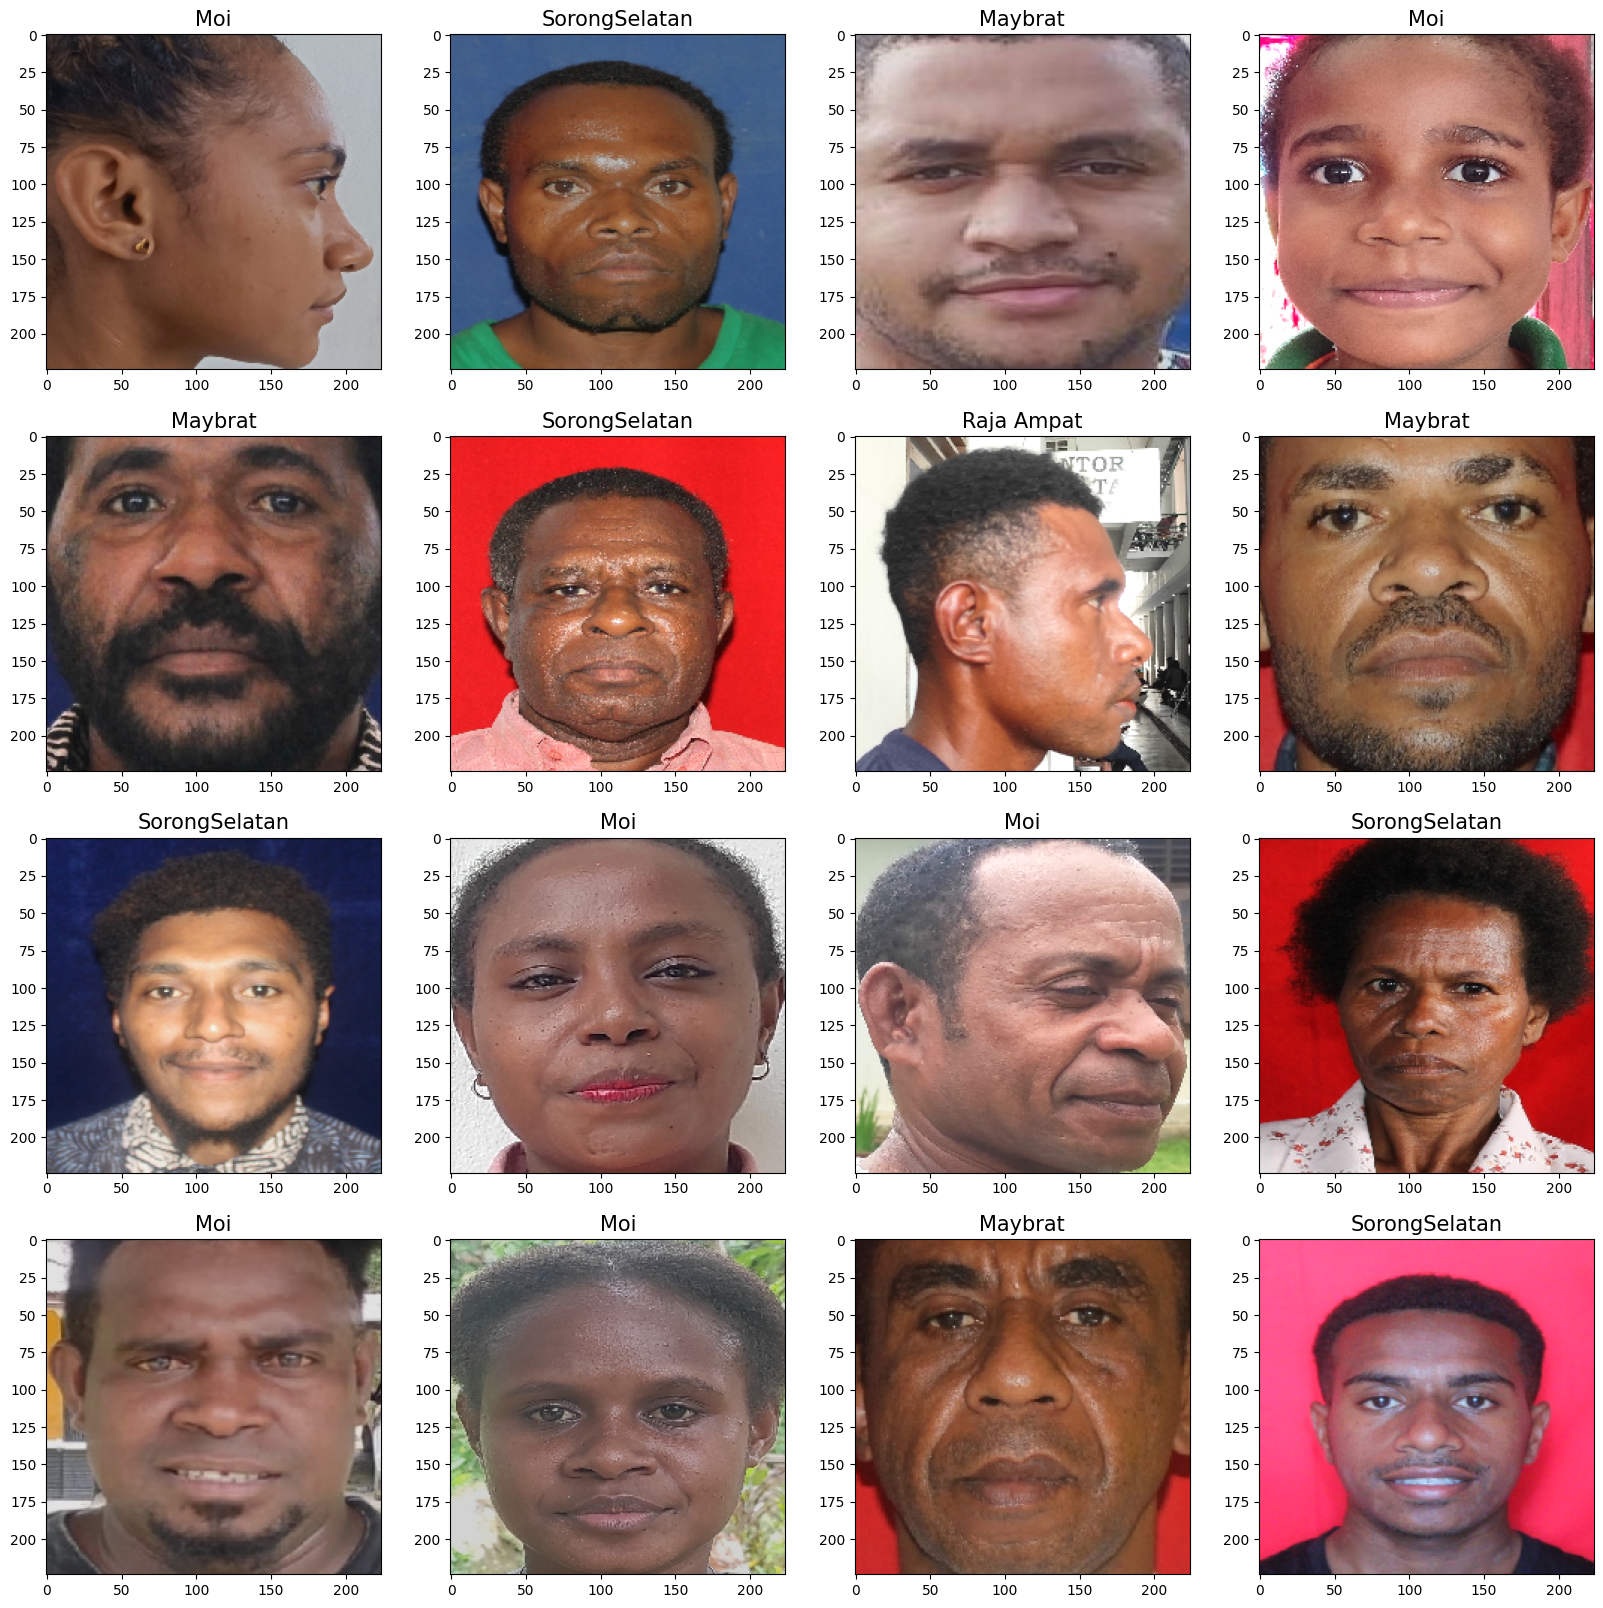

In [14]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(ts_gen)
plt.figure(figsize=(20, 20))
for i, (image, label) in enumerate(zip(images, labels)):
 plt.subplot(4,4, i + 1)
 plt.imshow(image)
 class_name = classes[np.argmax(label)]
 plt.title(class_name, color='k', fontsize=15)
plt.show()

In [15]:
#img_shape=(224,224,3)
#base_model = ResNet50(include_top=False, weights="imagenet",
#                     input_shape=img_shape, pooling='max')


#from tensorflow.keras.regularizers import l2
#from tensorflow.keras.layers import Dropout

#model = Sequential([
#    base_model,
#    Flatten(),
#    Dense(256, activation="relu", kernel_regularizer=l2(0.001)),
#    Dropout(0.4),
#    Dense(128, activation="relu", kernel_regularizer=l2(0.001)),
#    Dropout(0.3),
#    Dense(64, activation="relu", kernel_regularizer=l2(0.001)),
#    Dropout(0.3),
#    Dense(4
#          , activation="softmax")
#])

#model.compile(optimizer=Adamax(learning_rate=0.0003),
#              loss='categorical_crossentropy',
#              metrics=['accuracy',
#                       Precision(name='precision'),
#                       Recall(name='recall')])


#model.summary()


In [16]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.regularizers import l2


# Ukuran input gambar
img_shape = (224, 224, 3)

# 1. Load pre-trained ResNet50 (tanpa top classifier, dengan bobot dari ImageNet)
base_model = ResNet50(include_top=False, weights='imagenet',
                      input_shape=img_shape, pooling='max')

# 2. Freeze semua layer awal untuk melindungi bobot ImageNet
base_model.trainable = False

# 3. Buat model baru di atas base_model
model = Sequential([
    base_model,
    Flatten(),  # Atau bisa diganti dengan GlobalAveragePooling2D()
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(4, activation='softmax')  # Output untuk klasifikasi 4 kelas
])

# 4. Kompilasi model
model.compile(
    optimizer=Adamax(learning_rate=0.0004),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

# 5. Lihat ringkasan model
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,153,668 (92.14 MB)

 Trainable params: 565,956 (2.16 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [17]:
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

In [18]:
hist = model.fit(tr_gen,
                 epochs=50,
                 validation_data=ts_gen,
                 shuffle= False)

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 42s 886ms/step - accuracy: 0.2507 - loss: 5.1276 - precision: 0.2516 - recall: 0.2104 - val_accuracy: 0.2086 - val_loss: 2.0643 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 28s 782ms/step - accuracy: 0.3296 - loss: 1.9946 - precision: 0.2686 - recall: 0.0043 - val_accuracy: 0.2374 - val_loss: 2.0012 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 28s 798ms/step - accuracy: 0.2720 - loss: 1.9842 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2410 - val_loss: 1.9733 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 28s 798ms/step - accuracy: 0.2742 - loss: 1.9678 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.3022 - val_loss: 1.9588 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 28s 798ms/step - accuracy: 0.2738 - loss: 1.9542 - precision: 0.1459 -

In [19]:
hist.history.keys()

dict_keys(['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall'])

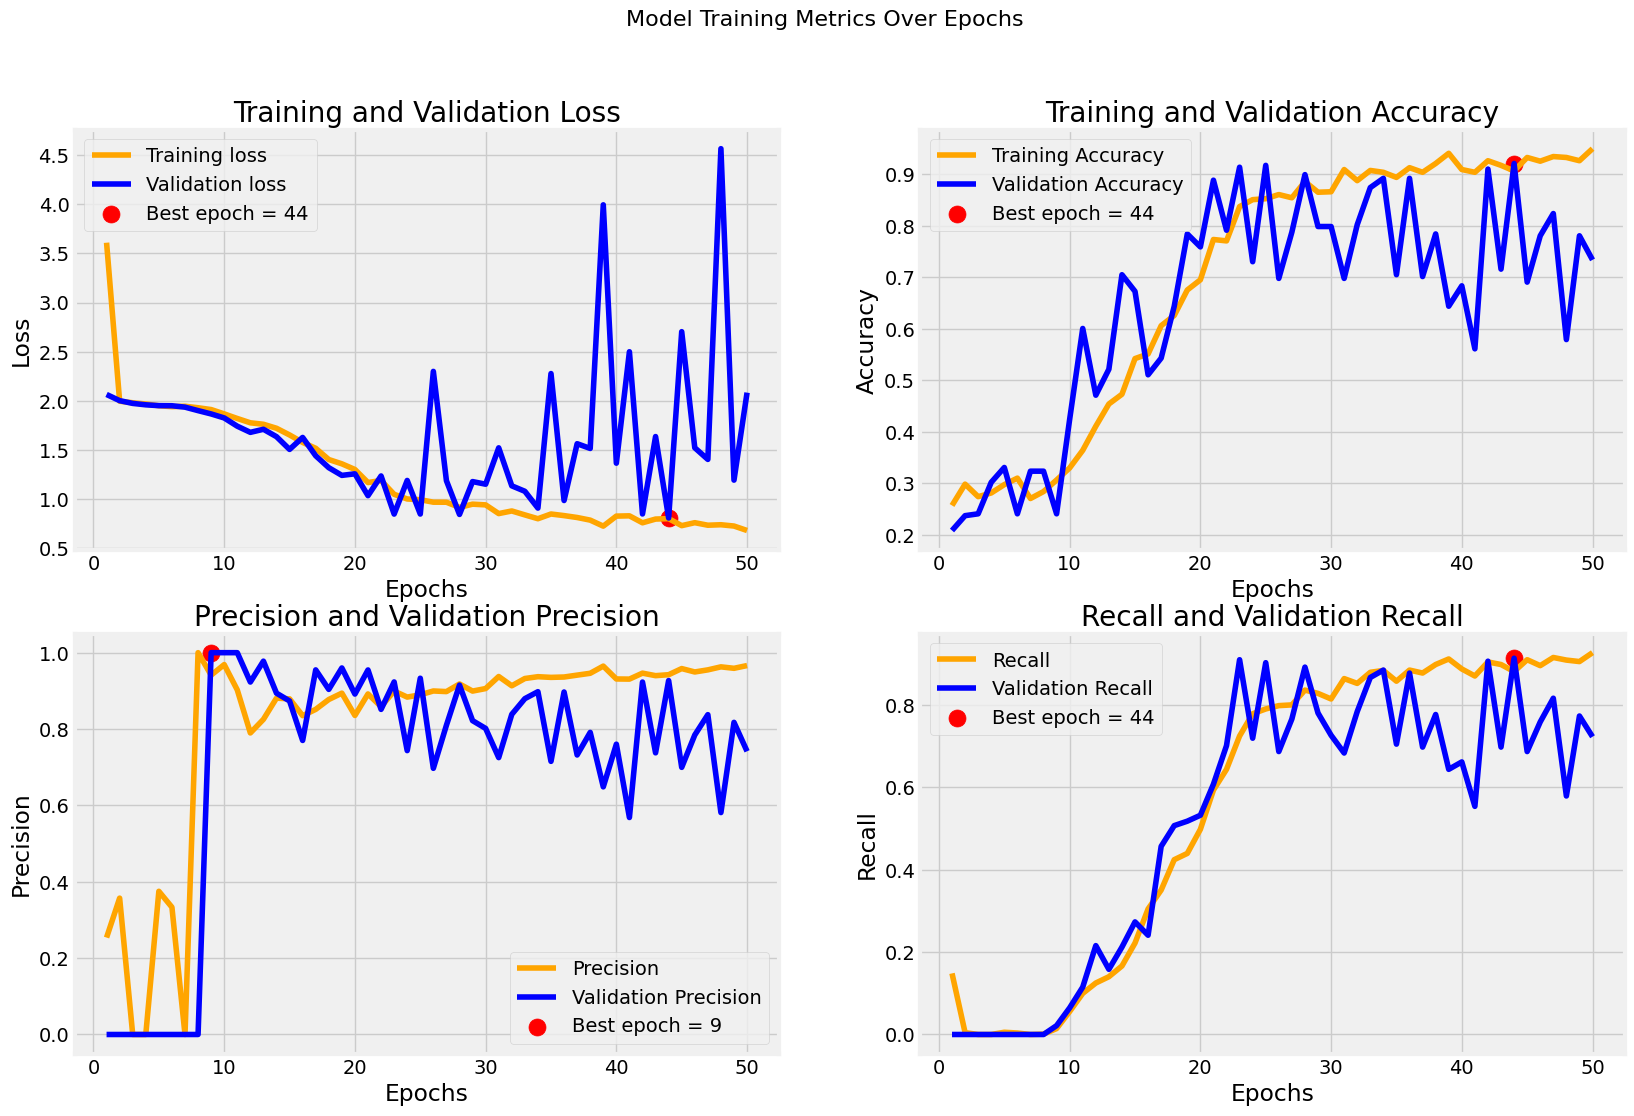

In [20]:
tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
tr_per = hist.history['precision']
tr_recall = hist.history['recall']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
val_per = hist.history['val_precision']
val_recall = hist.history['val_recall']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'


plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')


plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'orange', label='Training loss')
plt.plot(Epochs, val_loss, 'blue', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='r', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'orange', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'blue', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='r', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'orange', label='Precision')
plt.plot(Epochs, val_per, 'blue', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='r', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'orange', label='Recall')
plt.plot(Epochs, val_recall, 'blue', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='r', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

In [21]:
train_score = model.evaluate(tr_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

35/35 ━━━━━━━━━━━━━━━━━━━━ 18s 495ms/step - accuracy: 0.6944 - loss: 2.3518 - precision: 0.6994 - recall: 0.6872
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 244ms/step - accuracy: 0.7032 - loss: 2.3757 - precision: 0.7090 - recall: 0.6991
Train Loss: 2.4019
Train Accuracy: 68.53%
--------------------
Test Loss: 2.2888
Test Accuracy: 70.14%


In [22]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 342ms/step


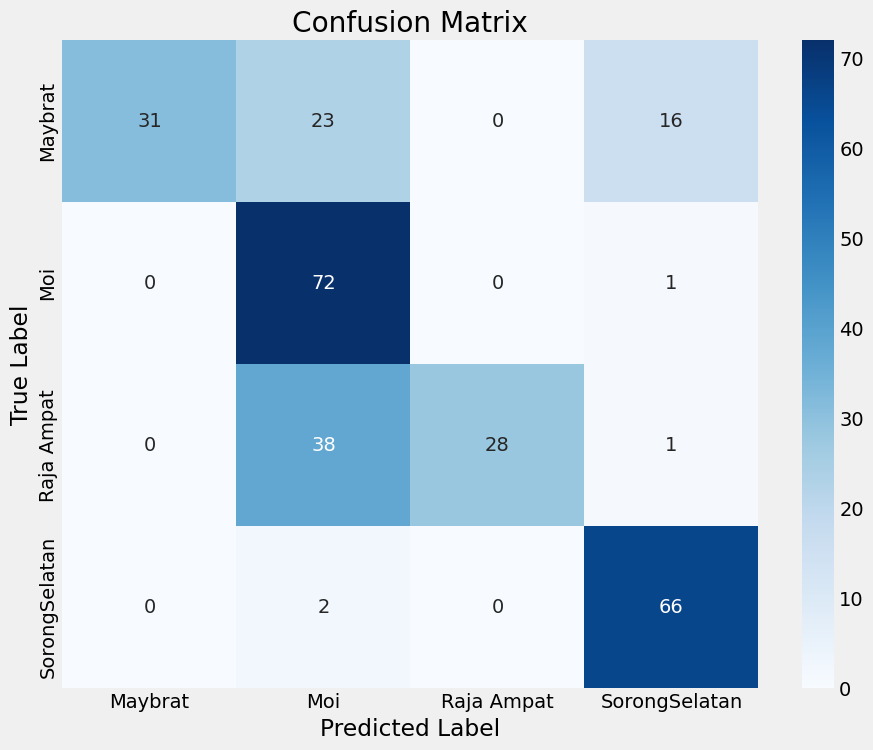

               precision    recall  f1-score   support

      Maybrat       1.00      0.44      0.61        70
          Moi       0.53      0.99      0.69        73
   Raja Ampat       1.00      0.42      0.59        67
SorongSelatan       0.79      0.97      0.87        68

     accuracy                           0.71       278
    macro avg       0.83      0.70      0.69       278
 weighted avg       0.83      0.71      0.69       278



In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Ambil label kelas dari generator
labels = list(ts_gen.class_indices.keys())

# Konversi y_pred ke bentuk kelas jika masih dalam probabilitas
if y_pred.ndim > 1:  # Jika berbentuk (n_samples, n_classes)
    y_pred_classes = y_pred.argmax(axis=1)
else:
    y_pred_classes = y_pred  # Jika sudah berupa label langsung

# Buat confusion matrix
cm = confusion_matrix(ts_gen.classes, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Tampilkan classification report
clr = classification_report(ts_gen.classes, y_pred_classes, target_names=labels)
print(clr)

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

labels = ["Tehit","Maybrat", "Moi Maya", "Moi Kelim", "Kokoda"]

def predict(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = np.expand_dims(img, axis=0)
    img = img / 255.0

    predictions = model.predict(img)
    probs = list(predictions[0])

    # Cek kesesuaian jumlah label dan probabilitas
    if len(probs) != len(labels):
        print(f"Error: The model produces {len(probs)} probability, but there is only {len(labels)} label!")
        return

    # Menampilkan gambar
    plt.figure(figsize=(6, 6))
    plt.subplot(2, 1, 1)
    plt.imshow(cv2.imread(img_path))
    plt.axis("off")
    plt.title("Input Image", fontsize=9)

    # Menampilkan hasil prediksi dalam bentuk bar chart
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs, color='skyblue')

    # Menambahkan teks akurasi di dalam balok
    for bar, prob in zip(bars, probs):
        plt.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
                 f"{prob:.2%}", va='center', fontsize=9, color='black')

    plt.xlabel('Probability', fontsize=9)
    plt.xlim(0, 1)  # Set batas nilai x-axis dari 0 sampai 1
    plt.title("Prediction Confidence", fontsize=9)
    plt.show()

In [25]:
predict('/content/drive/MyDrive/WajahSorongRaya2/SorongSelatan/tahoba5602990004.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Error: The model produces 4 probability, but there is only 5 label!


In [26]:
predict('/content/drive/MyDrive/WajahSorongRaya2/Moi/IMG-20230427-WA0015.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Error: The model produces 4 probability, but there is only 5 label!


In [27]:
predict("/content/drive/MyDrive/WajahSorongRaya2/Maybrat/9171030408830005.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
Error: The model produces 4 probability, but there is only 5 label!


In [28]:
predict("/content/drive/MyDrive/WajahSorongRaya2/SorongSelatan/gogoba26405920004.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Error: The model produces 4 probability, but there is only 5 label!


In [29]:
predict("/content/drive/MyDrive/WajahSorongRaya2/SorongSelatan/wugaje5309901001.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
Error: The model produces 4 probability, but there is only 5 label!


######